In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import pytest
from persist.persist import PersistentDAG
from functools import wraps

# global variable to simulate the fact to have serialize data somewhere
IS_COMPUTED = dict()

from time import sleep
def load_data(**kwargs):
    sleep(2)
    print 'load data ...'
    if kwargs:
        print kwargs
        return 'data_{}'.format(kwargs)
    return 'data'


def clean_data(data):
    assert isinstance(data, str)
    print 'clean data ...'
    return 'cleaned_{}'.format(data)


def analyze_data(cleaned_data, option=1, **other_options):
    assert isinstance(cleaned_data, str)
    print 'analyze data ...'
    return 'analyzed_{}'.format(cleaned_data)



class Serializer(object):
    def __init__(self):
        pass

    def load(self, key):
        print "load data for key {} ...".format(key)
        return IS_COMPUTED[key]

    def dump(self, key, value):
        print "save data with key {} ...".format(key)
        IS_COMPUTED[key] = value

    def is_computed(self, key):
        return IS_COMPUTED.get(key) is not None

    def delayed_load(self, key):
        def load():
            return self.load(key)
        return load

    def dump_result(self, func, key):
        @wraps(func)
        def wrapped_func(*args, **kwargs):
            result = func(*args, **kwargs)
            self.dump(key, result)
            return result
        return wrapped_func


def setup_graph(**kwargs):
    g = PersistentDAG(**kwargs)
    serializer = Serializer()
    for pool in ['pool1', 'pool2']:
        g.add_task(('data', pool), serializer, load_data)
        g.add_task(('cleaned_data', pool), serializer,
                   clean_data, ('data', pool))
        g.add_task(('analyzed_data', pool), serializer,
                   analyze_data, ('cleaned_data', pool))
    return g



In [3]:

global IS_COMPUTED
IS_COMPUTED = dict()
g = setup_graph(use_cluster=False)

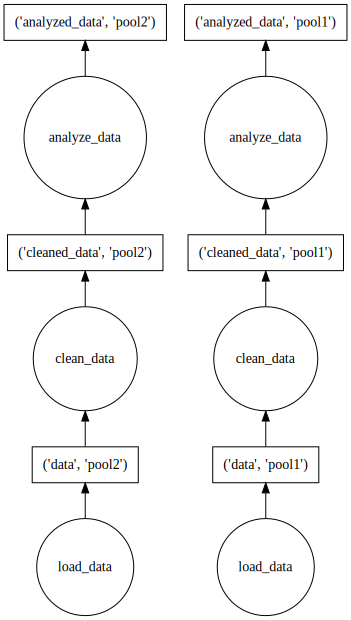

In [4]:
g.visualize(format='svg')

In [6]:
g.run()

{('analyzed_data', 'pool1'): 'analyzed_cleaned_data',
 ('analyzed_data', 'pool2'): 'analyzed_cleaned_data',
 ('cleaned_data', 'pool1'): 'cleaned_data',
 ('cleaned_data', 'pool2'): 'cleaned_data',
 ('data', 'pool1'): 'data',
 ('data', 'pool2'): 'data'}

In [10]:
from dask.delayed import to_task_dask

In [21]:
g.dsk

{('analyzed_data', 'pool1'): (<function apply>,
  <function __main__.analyze_data>,
  [],
  (dict, [['cleaned_data', ('cleaned_data', 'pool1')], ['option', 1]])),
 ('analyzed_data', 'pool2'): (<function apply>,
  <function __main__.analyze_data>,
  [],
  (dict, [['cleaned_data', ('cleaned_data', 'pool2')], ['option', 1]])),
 ('cleaned_data', 'pool1'): (<function apply>,
  <function __main__.clean_data>,
  [],
  (dict, [['data', ('data', 'pool1')]])),
 ('cleaned_data', 'pool2'): (<function apply>,
  <function __main__.clean_data>,
  [],
  (dict, [['data', ('data', 'pool2')]])),
 ('data', 'pool1'): (<function __main__.load_data>,),
 ('data', 'pool2'): (<function __main__.load_data>,)}

In [20]:
task, dask = to_task_dask(g.funcs)
dict(dask)

{('analyzed_data', 'pool1'): (<function apply>,
  <function __main__.analyze_data>,
  [],
  (dict, [['cleaned_data', ('cleaned_data', 'pool1')], ['option', 1]])),
 ('analyzed_data', 'pool2'): (<function apply>,
  <function __main__.analyze_data>,
  [],
  (dict, [['cleaned_data', ('cleaned_data', 'pool2')], ['option', 1]])),
 ('cleaned_data', 'pool1'): (<function apply>,
  <function __main__.clean_data>,
  [],
  (dict, [['data', ('data', 'pool1')]])),
 ('cleaned_data', 'pool2'): (<function apply>,
  <function __main__.clean_data>,
  [],
  (dict, [['data', ('data', 'pool2')]])),
 ('data', 'pool1'): (<function __main__.load_data>,),
 ('data', 'pool2'): (<function __main__.load_data>,)}

In [12]:
from distributed import Client
from time import sleep
import random

def inc(x):
    sleep(random.random() / 10)
    return x + 1

def dec(x):
    sleep(random.random() / 10)
    return x - 1

def add(x, y):
    sleep(random.random() / 10)
    return x + y


client = Client()

incs = client.map(inc, range(100))
decs = client.map(dec, range(100))
adds = client.map(add, incs, decs)
total = client.submit(sum, adds)

del incs, decs, adds
total.result()

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP st

9900

In [13]:
global IS_COMPUTED
IS_COMPUTED = dict()
g = setup_graph(use_cluster=True)

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP st

In [16]:
# persist assert en error because the given collection is not of type
# dask.base.Base
futures = g.async_run()
data = map(lambda x: x.compute(), reversed(futures))

In [18]:
sorted(data)

["analyzed_cleaned_data_{'kwargs': {}}",
 "analyzed_cleaned_data_{'kwargs': {}}",
 "cleaned_data_{'kwargs': {}}",
 "cleaned_data_{'kwargs': {}}",
 "data_{'kwargs': {}}",
 "data_{'kwargs': {}}"]

In [17]:
assert sorted(data) == ['analyzed_data', 'analyzed_data',
                        'cleaned_data', 'cleaned_data', 'data', 'data']

data = g.client.gather(futures)
# here I do not know why gather still return delayed objects...
# assert isinstance(data[0], str)

AssertionError: 

In [25]:

print futures[0].status

Delayed('getattr-5d4165937d9342af4836dc5ec0e96384')


In [7]:
# global variable to simulate the fact to have serialize data somewhere
IS_COMPUTED = dict()

from functools import partial
from dask import get
from dask.optimize import cull
from functools import wraps
import inspect
        
def load_data():
    print 'load data ...'
    return 'data'

def clean_data(data):
    assert isinstance(data, str)
    assert data == 'data'
    print 'clean data ...'
    return 'cleaned_data'

def analyze_data(cleaned_data, option=1, **other_options):
    assert isinstance(cleaned_data, str)
    assert cleaned_data == 'cleaned_data'
    print 'analyze data ...'
    return 'analyzed_data'

class Serializer(object):
    def __init__(self):
        pass

    def load(self, key):
        print "load data for key {} ...".format(key)
        return key
    
    def dump(self, key, value):
        print "save data with key {} ...".format(key)
        IS_COMPUTED[key] = True
        
    def is_computed(self, key):
        return IS_COMPUTED.get(key)
    
    def delayed_load(self, key):
        def load():
            return self.load(key)
        return load
    
    def dump_result(self, func, key):
        @wraps(func)
        def wrapped_func(*args, **kwargs):
            result =  func(*args, **kwargs)
            self.dump(key, result)
            return result
        return wrapped_func


class Graph(object):
    def __init__(self):
        self.dsk = dict()
        self.cache = dict()
        self.serializer = dict()
        
    def add_task(self, key, serializer, func, *args, **kwargs):
        self.serializer[key] = serializer
        # prepare arguments for the dask graph specification
        args_dict = inspect.getcallargs(func, *args, **kwargs)
        args_spec = inspect.getargspec(func)
        args_list = [args_dict[argname] for argname in args_spec.args]
        # dump data as side effect
        func = serializer.dump_result(func, key)
        # propagate keyword arguments
        if args_spec.keywords:
            func = partial(func, **args_dict[args_spec.keywords])
        # add task to dask graph
        self.dsk[key] = (func,) + tuple(args_list)
        return key
        
    @property
    def persistent_dsk(self):
        dsk = self.dsk.copy()
        # load instead of compute
        # the fact to call the method "is_computed" may slow down the code.
        dsk.update({key : (self.serializer[key].delayed_load(key),) for key in dsk.keys() if key in self.serializer and self.serializer[key].is_computed(key)})
        #Use cache instead of loadind
        dsk.update({key : self.cache[key] for key in dsk.keys() if key in self.cache})
        return dsk
        
    def run(self, key=None):
        if key is None:
            key = self.dsk.keys()
        dsk = self.persistent_dsk
        dsk, _ = cull(dsk, key)
        # get all necessary results
        keys = dsk.keys()
        results = dict(zip(keys, get(dsk, keys)))
        # store in cache
        self.cache.update(results)
        
    def get(self, key):
        self.run(key)
        try:
            return self.cache[key]
        except (TypeError, KeyError):
            return {k : self.cache[k] for k in key}
    

def setup_graph(**kwargs):
    g = Graph()
    serializer = Serializer()
    for pool in ['pool1', 'pool2']:
        g.add_task(('data', pool), serializer, load_data)
        g.add_task(('cleaned_data', pool), serializer, clean_data, ('data', pool) )
        g.add_task(('analyzed_data', pool), serializer, analyze_data, ('cleaned_data', pool))
    return g

g = setup_graph()
data = g.get(('analyzed_data', 'pool1'))
print "data=", data
print "Checking that it is cached"
data = g.get(('analyzed_data', 'pool1'))
print "data=", data
data = g.get(('cleaned_data', 'pool1'))
print "data=", data
print ""


data = g.get(('cleaned_data', 'pool2'))
print "data=", data
print ""


data = g.get(('analyzed_data', 'pool2'))
print "data=", data
print ""

print "get multiple results"
g.get([('analyzed_data', 'pool1'), ('analyzed_data', 'pool2')])




load data ...
save data with key ('data', 'pool1') ...
clean data ...
save data with key ('cleaned_data', 'pool1') ...
analyze data ...
save data with key ('analyzed_data', 'pool1') ...
data= analyzed_data
Checking that it is cached
data= analyzed_data
data= cleaned_data

load data ...
save data with key ('data', 'pool2') ...
clean data ...
save data with key ('cleaned_data', 'pool2') ...
data= cleaned_data

analyze data ...
save data with key ('analyzed_data', 'pool2') ...
data= analyzed_data

get multiple results


{('analyzed_data', 'pool1'): 'analyzed_data',
 ('analyzed_data', 'pool2'): 'analyzed_data'}

In [ ]:
import inspect
func = analyze_data

args_dict = inspect.getcallargs(func, "toto", 2, test=True)
args_spec = inspect.getargspec(func)
args_list = [args_dict[argname] for argname in args_spec.args]


In [ ]:
from pprint import pprint


IS_COMPUTED = dict()
g = setup_graph()
# the first time the grap is created it has functions
pprint(g.persistent_dsk)
# run the graph
g.run()
# then the graph is replaced by cached data
pprint(g.persistent_dsk)

# If we recreate a new graph (the cache is delete)
g = setup_graph()
# the graph conainte the load methods
pprint(g.persistent_dsk)


print "get multiple results"
data = g.get([('analyzed_data', 'pool1'), ('analyzed_data', 'pool2')])
print "data=", data



In [ ]:
from dask.base import Base
Base()

In [ ]:
from dask.bag import Bag
b =Bag(g.dsk, ('analyzed_data', 'pool2'), None)
b.compute()

In [ ]:
from dask import delayed

In [ ]:
data = delayed(load_data)(dask_key_name=('data', 'pool1'))
cleaned_data= delayed(clean_data)(dask_key_name=('cleaned_data', 'pool1'), **dict(data=data))
cleaned_data.compute()

In [ ]:
cleaned_data.visualize(format='svg')

In [ ]:
get(cleaned_data.dask, ('cleaned_data', 'pool1'))